In [2]:
import numpy as np
import matplotlib.pyplot as plt


In [52]:
# parameters
eps11 = -30 #MHz 
dt  = 1e6 #ns
tau_b = 1e9 #ns
tau_eps = 1e7 #ns
sig_eps = 0.5 #mV
sig_b = 0 #MHz
sig_Jr = 0.0 #MHz
tau_Jr = 1e7 #ns
realisations = 1000
sig_measure = 0.5 #MHz

params0 = {"eps11": eps11, 
           "dt" : dt, 
           "tau_b" : tau_b, 
           "tau_eps": tau_eps, 
           "sig_eps":sig_eps, 
           "sig_b": sig_b, 
           "realisations": realisations, 
           "sig_measure": sig_measure,
           "tau_Jr": tau_Jr,
           "sig_Jr": sig_Jr}


def J(eps, J0 = 20, J1 = 725, eps0 = 4.4):
    return J0 + J1*np.exp(eps/eps0)

def dJ(eps, J0 = 20, J1 = 725, eps0 = 4.4):
    return J1/eps0*np.exp(eps/eps0)


def eps_J(J, J0 = 20, J1 = 725, eps0 = 4.4):
    return (np.log((J - J0)/J1))*eps0

# single step of o-u process with time step dt, and correlation time tau, and variance sigma
def ou_step(x, dt, tau, sigma):
    return x - dt/tau * x + np.sqrt(dt/tau) * sigma * np.random.randn()

# simulate the o-u process with time step dt, and correlation time tau, and variance sigma
def ou_process(dt, tau, sigma, n):
    x = np.zeros(n)
    x[0]  = np.random.randn()
    for i in range(1, n):
        x[i] = ou_step(x[i-1], dt, tau, sigma)
    return x

# simulate the measurement of the frequency with noise
def measure(B, dJr, eps, params = params):
    om_ideal = np.sqrt(B**2 + (J(eps)+dJr)**2)
    noise = params["sig_measure"]*np.random.randn()
    return om_ideal + noise


# simulate the measurement of the frequencies at two detunigs with noise
def single_run(N, B0, deps0, Bmin, feedback=True, params = params0):

    measured_om = {"11": [], "02": []} 
    error_om = {"11": [], "02": []}
    Bs = [(B0,0)]
    dJr = [(0,0)]
    Js = [(J(eps11),0)]
    deps = [(deps0,0)]
    B_est = []
    Bs_used = []
    eps_f = 0
    n = 0
    timestamp = 0
    while n < N:
        #measurm at at (1,1)
        Bs.append((ou_step(Bs[-1][0], params["dt"], params["tau_b"], params["sig_b"]),timestamp))
        deps.append((ou_step(deps[-1][0], params["dt"], params["tau_eps"], params["sig_eps"]),timestamp))
        dJr.append((ou_step(dJr[-1][0], params["dt"], params["tau_Jr"], params["sig_Jr"]),timestamp))
        
        eps = eps11+deps[-1][0]+eps_f
        Bs_used.append(False)


        measured_om["11"].append((measure(Bs[-1][0], dJr[-1][0], eps, params), timestamp))
        error_om["11"].append((measured_om["11"][-1][0] - np.sqrt(Bs[-1][0]**2 + Js[-1][0]**2), timestamp)) #Error between estimation and the real om11

        timestamp += dt
        
        #inference of B
        B_est.append((np.sqrt(measured_om["11"][-1][0]**2 - J(eps11)**2),timestamp))  #our estimation of B
        
        
        if B_est[-1][0] > Bmin:
            Bs_used.append(True)
            eps02 = eps_J(B_est[-1][0])  #set detuning to Hadamrd
        
            #measurment at (0,2)
            Bs.append((ou_step(Bs[-1][0], params["dt"], params["tau_b"], params["sig_b"]),timestamp))
            deps.append((ou_step(deps[-1][0], params["dt"], params["tau_eps"], params["sig_eps"]),timestamp))
            dJr.append((ou_step(dJr[-1][0], params["dt"], params["tau_Jr"], params["sig_Jr"]),timestamp))
            
            eps = eps02+deps[-1][0]+eps_f
            Js.append((J(eps), timestamp))
            
            measured_om["02"].append((measure(Bs[-1][0], dJr[-1][0], eps, params), timestamp))
            error_om["02"] = measured_om["02"][-1][0] - np.sqrt(Bs[-1][0]**2 + Js[-1][0])

            timestamp += dt
            #Feedback on eps:
            if feedback:
                eps_f -= (np.sqrt(measured_om["02"][-1][0]**2-B_est[-1][0]**2) - B_est[-1][0])/dJ(eps02)
            else:
                eps_f = 0
            n += 1
            
    return np.array(Bs), np.array(Js), np.array(B_est),measured_om, error_om, Bs_used
    

def get_Q(Js, Bs):
    ths = np.arctan2(Js,Bs)
    return np.sqrt(np.sum((ths-np.pi/4)**2))


def Q_statistics_trials(trials, params0):
    Q = []
    for tr in range(trials):
        Bs,Js, B_est, measured_om, error_om, Bs_used = single_run(N=50, B0= B0, deps0 = 0, Bmin = 30, feedback=True, params=params0)
        Q.append(get_Q(Js[1:,0], Bs[1:,0][Bs_used]))
    Q = np.array(Q)
    return Q.mean(), Q.std()





cc

In [57]:
#B0 = sig_B*np.random.randn()
B0 = 50
trials = 100
np.random.seed(6151)
std_measure = np.linspace(0, 2, 10)
Qstat = []
for s, std in enumerate(std_measure):
    print(s)
    params = params0.copy()
    params["sig_measure"] = std
    Qstat.append(Q_statistics_trials(trials, params))




0
1
2
3
4
5
6
7
8
9


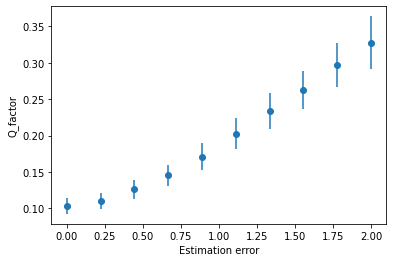

In [58]:
#plot Qstat
plt.figure()
plt.errorbar(std_measure, np.array(Qstat)[:,0], yerr=np.array(Qstat)[:,1], fmt='o')
plt.xlabel("Estimation error")
plt.ylabel("Q_factor")
plt.show()


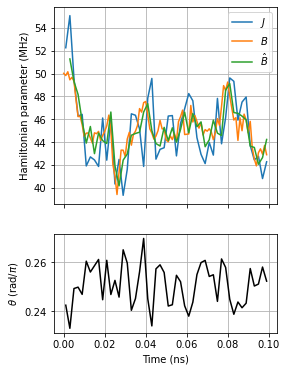

In [15]:

#create two subplots, in upper one plot B, B_est and J and in the other arctan2(J,B)
fig, ax = plt.subplots(2,1,figsize=(4,6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
ax[0].plot(Js_time[1:]/1e9,Js_val[1:], label="$J$")
ax[0].plot(Bs_time[1:]/1e9, Bs_val[1:], label="$B$")
ax[0].plot(B_est_time[1:]/1e9, B_est_val[1:], label = r"$\hat B$")
ax[0].legend()
ax[0].grid()
#ax[0].set_xlabel("Time (ns)")
ax[0].set_ylabel("Hamiltonian parameter (MHz)")
ax[1].plot(Js_time[1:]/1e9, np.arctan2(np.abs(Bs_val[1:][Bs_used]), Js_val[1:])/np.pi, "k", alpha=1)
ax[1].set_ylabel(r"$\theta$ (rad/$\pi$)")
ax[1].grid()
ax[1].set_xlabel("Time (ns)")
plt.savefig("estimation_simulation.png",dpi=200)